## Objective
The goal of the project is to train and test a random forest for bird classification, compare it with a decision tree and KNN classifier, and build a stacking ensemble with DT, KNN, and SVM as base learners, and Random Forest as the meta-model.

In [141]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import StratifiedKFold


import warnings

# Suppress warnings globally
warnings.filterwarnings("ignore", category=UserWarning)

In [142]:
# Load the image attributes and labels
imgatt = pd.read_csv("image_attribute_labels.txt", delim_whitespace=True, usecols=[0, 1, 2], header=None, names=['igid', 'attid', 'present'], on_bad_lines='skip')
imglabels = pd.read_csv("image_class_labels.txt", delim_whitespace=True, header=None, names=['igid', 'label'], on_bad_lines='skip')


## Exploratory data analysis

In [143]:
# print the shapes
print('The shape of the dataset : ', imgatt.shape)
print('The shape of the dataset : ', imglabels.shape)

The shape of the dataset :  (3677856, 3)
The shape of the dataset :  (11788, 2)


In [144]:
# preview the Datasets
imgatt.head()

,igid,attid,present
0,1,1,0
1,1,2,0
2,1,3,0
3,1,4,0
4,1,5,1


In [145]:
# preview the imglabeles Datasets
imglabels.head()

,igid,label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [146]:
# View summary of dataset 
print("\nSummary of Imgatt (Dataset):")
imgatt.info()
print("\nSummary of Imglabels (Dataset):")
imglabels.info()


Summary of Imgatt (Dataset):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3677856 entries, 0 to 3677855
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   igid     int64
 1   attid    int64
 2   present  int64
dtypes: int64(3)
memory usage: 84.2 MB

Summary of Imglabels (Dataset):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11788 entries, 0 to 11787
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   igid    11788 non-null  int64
 1   label   11788 non-null  int64
dtypes: int64(2)
memory usage: 184.3 KB


In [147]:
# View statistical properties of dataset
imgatt.describe()

,igid,attid,present
count,3.677856e+06,3.677856e+06,3.677856e+06
mean,5.894500e+03,1.565000e+02,1.008868e-01
std,3.402903e+03,9.006619e+01,3.011788e-01
min,1.000000e+00,1.000000e+00,0.000000e+00
25%,2.947750e+03,7.875000e+01,0.000000e+00
50%,5.894500e+03,1.565000e+02,0.000000e+00
75%,8.841250e+03,2.342500e+02,0.000000e+00
max,1.178800e+04,3.120000e+02,1.000000e+00


In [148]:
# View statistical properties of dataset
imglabels.describe()

,igid,label
count,11788.000000,11788.000000
mean,5894.500000,101.126315
std,3403.046821,57.476826
min,1.000000,1.000000
25%,2947.750000,51.000000
50%,5894.500000,101.000000
75%,8841.250000,151.000000
max,11788.000000,200.000000


In [149]:
# Check for Missing Values
imgatt.isnull().sum()
imglabels.isnull().sum()

igid     0
label    0
dtype: int64

In [150]:
# Check for duplicate rows in imgatt
duplicates_imgatt = imgatt.duplicated()
num_duplicates_imgatt = duplicates_imgatt.sum()
print(f"Number of duplicate rows in imgatt: {num_duplicates_imgatt}")

# If there are duplicates, display them (optional)
if num_duplicates_imgatt > 0:
    print("Duplicate rows in imgatt:")
    print(imgatt[duplicates_imgatt])

# Check for duplicate rows in imglabels
duplicates_imglabels = imglabels.duplicated()
num_duplicates_imglabels = duplicates_imglabels.sum()
print(f"\nNumber of duplicate rows in imglabels: {num_duplicates_imglabels}")

# If there are duplicates, display them (optional)
if num_duplicates_imglabels > 0:
    print("Duplicate rows in imglabels:")
    print(imglabels[duplicates_imglabels])


Number of duplicate rows in imgatt: 0

Number of duplicate rows in imglabels: 0


## Observation

## imgatt Dataset:

- This dataset is large (3.68 million rows) and detailed, mapping each image ID to its possible attributes.
- Attributes are represented in a long format and need to be pivoted to analyze all attributes for a single image at once.

## imglabels Dataset:

- It is much smaller than imgatt and provides concise mappings between images and their respective classes.
- No missing values or duplicates ensure data consistency.

## Data Suitability:

- Both datasets are clean, with no missing or duplicate rows.
- The datasets are ready for further preprocessing, such as pivoting imgatt and merging it with imglabels to link attributes to labels.

## Next Steps:

- Transforming imgatt to a wide format to summarize attributes for each image.
- Merging the datasets on igid to create a unified dataset for machine learning.

## Data Transformation

In [151]:
# Pivot the table to wide format
imgatt2 = imgatt.pivot(index="igid", columns="attid", values="present")

# Output the head of the new arrangement and the number of rows and columns
print("Head of imgatt2:")
print(imgatt2.head())

print("\nNumber of rows and columns in imgatt2:")
print(imgatt2.shape)

Head of imgatt2:
attid  1    2    3    4    5    6    7    8    9    10   ...  303  304  305  \
igid                                                     ...                  
1        0    0    0    0    1    0    0    0    0    0  ...    0    0    0   
2        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3        0    0    0    0    1    0    0    0    0    0  ...    0    0    0   
4        0    0    0    0    1    0    0    0    0    0  ...    0    0    0   
5        0    0    0    0    1    0    0    0    0    0  ...    0    0    1   

attid  306  307  308  309  310  311  312  
igid                                      
1        0    0    1    0    0    0    0  
2        0    0    0    0    0    0    0  
3        0    0    1    0    0    1    0  
4        1    0    0    1    0    0    0  
5        0    0    0    0    0    0    0  

[5 rows x 312 columns]

Number of rows and columns in imgatt2:
(11788, 312)


## Data Merging and Shuffle

In [152]:
# Merge imgatt2 and imglabels on the common column 'igid'
merged_df = imgatt2.merge(imglabels, left_index=True, right_index=True)
merged_df

,1,2,3,4,5,6,7,8,9,10,...,305,306,307,308,309,310,311,312,igid,label
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,2,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,4,1
4,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,5,1
5,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11783,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,1,11784,200
11784,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,11785,200
11785,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,11786,200
11786,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,11787,200


In [153]:
# Shuffle the merged dataframe
shuffled_df = merged_df.sample(frac=1, random_state=10)

# Convert to numpy arrays
attributes_np = merged_df.drop(columns=['label']).values
labels_np = merged_df['label'].values

# Flatten the labels
labels_np = labels_np.flatten()

# Output shapes to verify
print("Attributes shape:", attributes_np.shape)
print("Labels shape (flattened):", labels_np.shape)

Attributes shape: (11787, 313)
Labels shape (flattened): (11787,)


In [154]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    attributes_np,    # Attributes (features)
    labels_np,        # Labels (target)
    test_size=0.2,    # 20% for testing
    random_state=42   # Reproducibility
)

# Output shapes of the splits
print("Training Set Shape (X_train):", X_train.shape)
print("Testing Set Shape (X_test):", X_test.shape)
print("Training Labels Shape (y_train):", y_train.shape)
print("Testing Labels Shape (y_test):", y_test.shape)


Training Set Shape (X_train): (9429, 313)
Testing Set Shape (X_test): (2358, 313)
Training Labels Shape (y_train): (9429,)
Testing Labels Shape (y_test): (2358,)


In [155]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=25, max_features=15, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_features=15, n_estimators=25, random_state=42)

In [156]:
# Predict on the training and testing data
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Calculate and print the accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy of Random Forest Classifier: {:.4f}".format(train_accuracy))
print("Testing Accuracy of Random Forest Classifier: {:.4f}".format(test_accuracy))


Training Accuracy of Random Forest Classifier: 0.9999
Testing Accuracy of Random Forest Classifier: 0.5004


## Observation
The large gap between the training accuracy (99.99%) and testing accuracy (50.04%) indicates overfitting. The model performs well on the training data but fails to generalize to new data

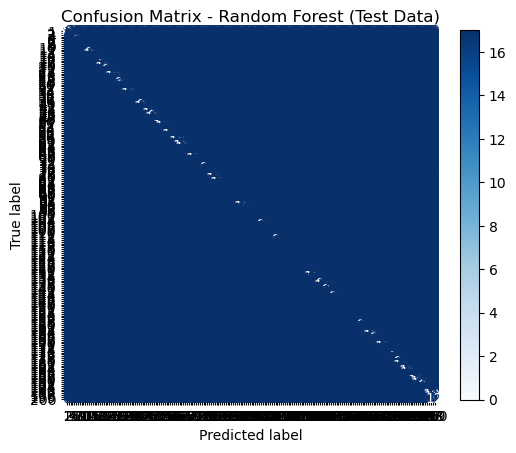

Precision: 0.5086
Recall: 0.5004
F1-Score: 0.4870


In [157]:
# Predict on the test data
y_test_pred = rf_classifier.predict(X_test)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest (Test Data)")
plt.show()

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print the metrics
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-Score: {:.4f}".format(f1))


In [158]:
# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier()  # Default k=5

# Train the KNN model
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [159]:
# Predict on the training and testing data
y_train_pred_knn = knn_classifier.predict(X_train)
y_test_pred_knn = knn_classifier.predict(X_test)

# Calculate and print training and testing accuracies
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)

print("Training Accuracy of KNN Classifier: {:.4f}".format(train_accuracy_knn))
print("Testing Accuracy of KNN Classifier: {:.4f}".format(test_accuracy_knn))

# Classification Report
#print("\nClassification Report (Test Data):")
#print(classification_report(y_test, y_test_pred_knn))


Training Accuracy of KNN Classifier: 0.9899
Testing Accuracy of KNN Classifier: 0.9843


In [160]:
# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()

# Train the Decision Tree model
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [161]:
# Predict on the training and testing data
y_train_pred_dt = dt_classifier.predict(X_train)
y_test_pred_dt = dt_classifier.predict(X_test)

# Calculate and print accuracies
train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt)
test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt)

print("Training Accuracy of Decision Tree Classifier: {:.4f}".format(train_accuracy_dt))
print("Testing Accuracy of Decision Tree Classifier: {:.4f}".format(test_accuracy_dt))



Training Accuracy of Decision Tree Classifier: 1.0000
Testing Accuracy of Decision Tree Classifier: 0.9843


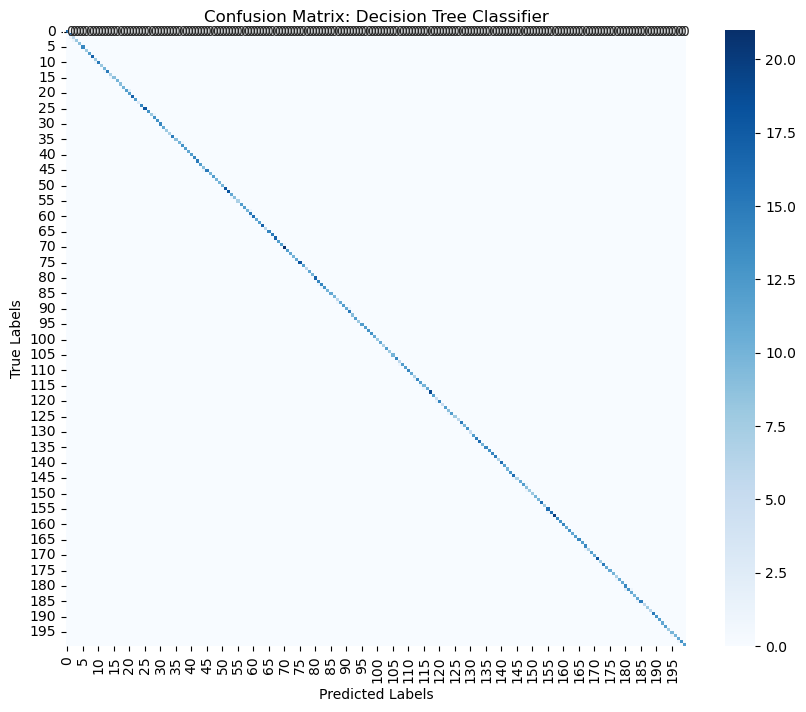

In [162]:
# Classification Report
#print("\nClassification Report (Test Data):")
#print(classification_report(y_test, y_test_pred_dt))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_dt)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Compare the performance of the RF, KNN and DT Models

## Analysis:
KNN performs exceptionally well, with a high testing accuracy of 0.9843, which closely matches the training accuracy of 0.9899.
The close match between training and testing accuracy indicates the model generalizes well and is not overfitting.
3. Decision Tree Classifier
Training Accuracy: 1.0000
Testing Accuracy: 0.9843
F1-Score: 0.4870
- Analysis:
The Decision Tree achieves perfect training accuracy, indicating it overfits the training data.
Despite the overfitting, its testing accuracy matches that of KNN at 0.9843.

## Overall Observations:
Best Performing Model:

- Based on testing accuracy, both KNN and Decision Tree are tied with an accuracy of 0.9843.
- KNN generalizes better due to its slightly lower training accuracy compared to Decision Tree.

- Worst Performing Model:

Random Forest struggles to generalize with a low testing accuracy of 0.5004, despite its high training accuracy. This indicates overfitting or poor hyperparameter tuning.

- Recommendation:

KNN is recommended as the most consistent model in terms of performance for this dataset, given its balance between training and testing accuracy.
While Decision Tree achieves similar testing accuracy, its perfect training score raises concerns about overfitting.

## Cross-Validation

In [163]:
# Initialize the models
rf_classifier = RandomForestClassifier(n_estimators=25, max_features=15, random_state=10)
knn_classifier = KNeighborsClassifier()
dt_classifier = DecisionTreeClassifier(random_state=10)

In [164]:
# Perform 5-fold cross-validation
rf_cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
knn_cv_scores = cross_val_score(knn_classifier, X_train, y_train, cv=5, scoring='accuracy')
dt_cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv=5, scoring='accuracy')

# Calculate mean and standard deviation for each model
rf_mean = np.mean(rf_cv_scores)
rf_std = np.std(rf_cv_scores)

knn_mean = np.mean(knn_cv_scores)
knn_std = np.std(knn_cv_scores)

dt_mean = np.mean(dt_cv_scores)
dt_std = np.std(dt_cv_scores)

# Print the results
print(f"Random Forest - Mean Accuracy: {rf_mean:.4f}, Std Deviation: {rf_std:.4f}")
print(f"KNN - Mean Accuracy: {knn_mean:.4f}, Std Deviation: {knn_std:.4f}")
print(f"Decision Tree - Mean Accuracy: {dt_mean:.4f}, Std Deviation: {dt_std:.4f}")


Random Forest - Mean Accuracy: 0.4766, Std Deviation: 0.0096
KNN - Mean Accuracy: 0.9768, Std Deviation: 0.0021
Decision Tree - Mean Accuracy: 0.9809, Std Deviation: 0.0040


## Hyperparameter Tuning

In [165]:
# Define parameter grid
param_grid = {
    'max_features': [5, 51, 5],
    'n_estimators': [10, 201, 10],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'random_state': [10]  
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'max_features': [5, 51, 5],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 201, 10], 'random_state': [10]},
             scoring='accuracy', verbose=2)

In [166]:
# Output the best settings
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best CV Score: {best_score:.4f}")

# Get results
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.sort_values(by='mean_test_score', ascending=False, inplace=True)

# Display top results
print(results_df.head())


Best Parameters: {'max_depth': 20, 'max_features': 51, 'min_samples_split': 5, 'n_estimators': 201, 'random_state': 10}
Best CV Score: 0.7438
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
28      41.682974      0.915067         2.072344        0.323055   
25      40.299114      2.929160         2.948430        0.442388   
7       27.706458      0.602134         2.163232        0.116411   
10      28.315369      0.416142         2.177379        0.243014   
27       2.270807      0.451007         0.158324        0.063623   

   param_max_depth param_max_features param_min_samples_split  \
28              20                 51                       5   
25              20                 51                       2   
7               10                 51                       2   
10              10                 51                       5   
27              20                 51                       5   

   param_n_estimators param_random_state  \
28            

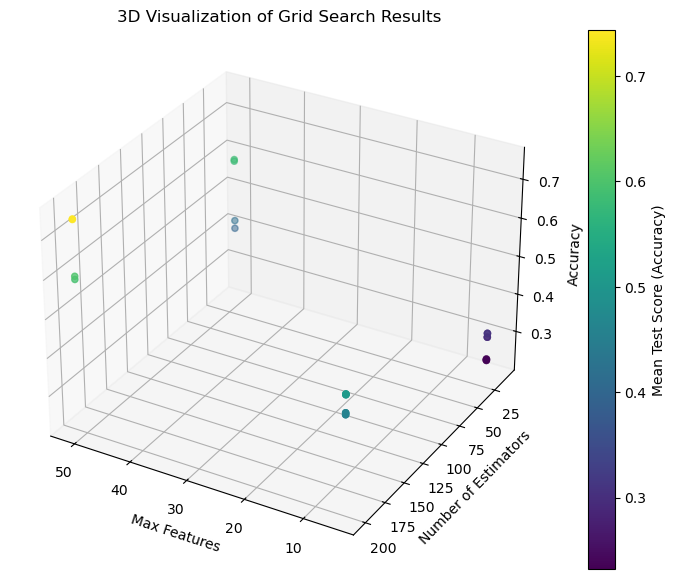

In [167]:
# Map non-numeric max_features values to numeric placeholders
feature_mapping = {'sqrt': 0.5, 'log2': 1.0}  # Example mappings
results_df['param_max_features_numeric'] = results_df['param_max_features'].replace(feature_mapping).astype(float)

# Ensure param_n_estimators is float
results_df['param_n_estimators'] = results_df['param_n_estimators'].astype(float)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    results_df['param_max_features_numeric'],
    results_df['param_n_estimators'],
    results_df['mean_test_score'],
    c=results_df['mean_test_score'], cmap='viridis', marker='o'
)

# Add color bar for mean_test_score
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Mean Test Score (Accuracy)')

# Set axis labels and title
ax.set_xlabel('Max Features')
ax.set_ylabel('Number of Estimators')
ax.set_zlabel('Accuracy')
plt.title('3D Visualization of Grid Search Results')

# Enhance grid and view
ax.grid(True)
ax.view_init(elev=30, azim=120)  # Adjust the view angle for better perspective

plt.show()


In [169]:
# Building the best parameters
best_params = grid_search.best_params_

# Step 1: Retrain Random Forest with the optimized settings
rf_optimized = RandomForestClassifier(
    n_estimators=best_params['n_estimators'], 
    max_features=best_params['max_features'],
    random_state=42
)

# Train the model on the entire training data
rf_optimized.fit(X_train, y_train)

# Step 2: Make predictions on the test data
y_pred_rf = rf_optimized.predict(X_test)

# Step 3: Evaluate the model performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')  # Adjusted for multiclass
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')  # Adjusted for multiclass
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')  # Adjusted for multiclass

# Step 4: Output the results
print(f"Random Forest Optimized Test Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest Optimized Test Precision (Weighted): {precision_rf:.4f}")
print(f"Random Forest Optimized Test Recall (Weighted): {recall_rf:.4f}")
print(f"Random Forest Optimized Test F1-Score (Weighted): {f1_rf:.4f}")


Random Forest Optimized Test Accuracy: 0.7519
Random Forest Optimized Test Precision (Weighted): 0.7738
Random Forest Optimized Test Recall (Weighted): 0.7519
Random Forest Optimized Test F1-Score (Weighted): 0.7521


## Stacking Ensemble

In [170]:
# Define base learners (Decision Tree, KNN, SVM)
base_learners = [
    ('decision_tree', DecisionTreeClassifier(random_state=42)),
    ('knn', KNeighborsClassifier()),
    ('svm', SVC(random_state=42))
]

# Define meta-model (Random Forest or Logistic Regression)
meta_model = LogisticRegression(random_state=42)  # Or use RandomForestClassifier()

# Create the stacking ensemble
stacking_ensemble = StackingClassifier(estimators=base_learners, final_estimator=meta_model)

In [171]:
# Train the stacking ensemble on the training data
stacking_ensemble.fit(X_train, y_train)

# Make predictions on the test data
y_pred_stack = stacking_ensemble.predict(X_test)

# Evaluate the model's performance
accuracy_stack = accuracy_score(y_test, y_pred_stack)
precision_stack = precision_score(y_test, y_pred_stack, average='weighted')  # Adjusted for multiclass
recall_stack = recall_score(y_test, y_pred_stack, average='weighted')  # Adjusted for multiclass
f1_stack = f1_score(y_test, y_pred_stack, average='weighted')  # Adjusted for multiclass

In [172]:
# Output the stacking ensemble test results
print(f"Stacking Ensemble Test Accuracy: {accuracy_stack:.4f}")
print(f"Stacking Ensemble Test Precision (Weighted): {precision_stack:.4f}")
print(f"Stacking Ensemble Test Recall (Weighted): {recall_stack:.4f}")
print(f"Stacking Ensemble Test F1-Score (Weighted): {f1_stack:.4f}")

Stacking Ensemble Test Accuracy: 0.7600
Stacking Ensemble Test Precision (Weighted): 0.7624
Stacking Ensemble Test Recall (Weighted): 0.7600
Stacking Ensemble Test F1-Score (Weighted): 0.7398


In [175]:
# Compare the performance of the stacking ensemble to the previous models
print("\nComparison with previous models:")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"KNN Accuracy: {test_accuracy_knn:.4f}")
print(f"Decision Tree Accuracy: {test_accuracy_dt:.4f}")



Comparison with previous models:
Random Forest Accuracy: 0.7519
KNN Accuracy: 0.9843
Decision Tree Accuracy: 0.9843


## Improving Performance my way

In [176]:
# Decision Tree Hyperparameter Tuning
dt_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=5)
dt_grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [177]:
# KNN Hyperparameter Tuning
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'metric': ['euclidean', 'manhattan']
}
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5)
knn_grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 10]})

In [178]:
# SVM Hyperparameter Tuning
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_grid_search = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=5)
svm_grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']})

In [182]:
# Output the best parameters and best score
best_params = svm_grid_search.best_params_
best_score = svm_grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best CV Score: {best_score:.4f}")

# Use the best model found from GridSearchCV to predict the test data
best_svm_model = svm_grid_search.best_estimator_

# Make predictions on the test data
y_pred_svm = best_svm_model.predict(X_test)

# Evaluate the accuracy of the model on the test data
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Test Accuracy of SVM: {accuracy_svm:.4f}")


Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV Score: 0.9780
Test Accuracy of SVM: 0.9784


In [179]:
# Output the best parameters
print(f"Best parameters for Decision Tree: {dt_grid_search.best_params_}")
print(f"Best parameters for KNN: {knn_grid_search.best_params_}")
print(f"Best parameters for SVM: {svm_grid_search.best_params_}")


Best parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 3}
Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [183]:
print("\nComparison with optimized models:")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"KNN Accuracy: {test_accuracy_knn:.4f}")
print(f"Test Accuracy of SVM: {accuracy_svm:.4f}")
print(f"Decision Tree Accuracy: {test_accuracy_dt:.4f}")
print(f"Stacking Ensemble Accuracy: {accuracy_stack:.4f}")



Comparison with optimized models:
Random Forest Accuracy: 0.7519
KNN Accuracy: 0.9843
Test Accuracy of SVM: 0.9784
Decision Tree Accuracy: 0.9843
Stacking Ensemble Accuracy: 0.7600


## Discussion of Model Comparisons on the Test Data

Among all the models, KNN and Decision Tree achieved the highest accuracy, suggesting they were particularly well-suited for this task. Both models attained a test accuracy of 0.9843, indicating they captured the underlying patterns effectively. The SVM also performed well with a test accuracy of 0.9784, providing a good balance between complexity and accuracy. It performed similarly to Decision Tree and KNN, suggesting that SVM is a strong contender for this dataset as well.

The Random Forest achieved a test accuracy of 0.7519, which, while respectable, was lower than that of the other models. Despite its robustness and ability to handle complex data, the Random Forest model did not perform as well as the more straightforward models like KNN and Decision Tree. 

The Stacking Ensemble, which combined Decision Tree, KNN, and SVM as base learners with Random Forest as the meta-model, achieved a test accuracy of 0.7600. While it showed some promise, it did not outperform the simpler models, indicating that the base models may have already captured most of the predictive power. This suggests that stacking may not always yield a significant performance improvement when the base models are already well-tuned.